In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from moabb.datasets import BI2013a

from power import field_root_mean_square, plot_fmrs
from data_processing import *

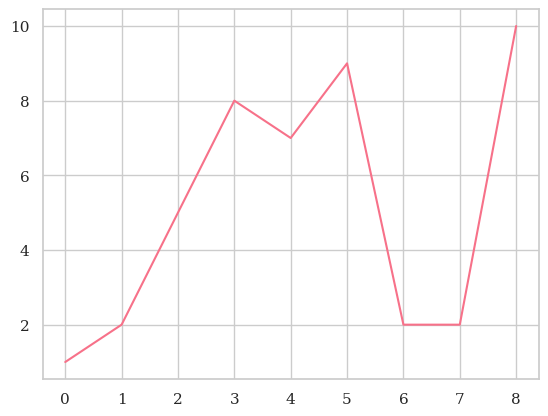

In [3]:
a = np.array([1,2,5,8,7,9,2,2,10])
plt.plot(a)

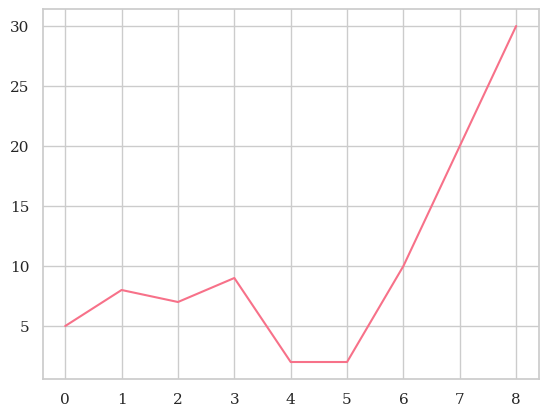

In [4]:
b = np.array([5,8,7,9,2,2,10,20,30])
plt.plot(b)

In [5]:
e_ = np.stack([np.expand_dims(a, axis=0), np.expand_dims(b, axis=0), np.expand_dims(a, axis=0)])
e_.shape, e_

((3, 1, 9),
 array([[[ 1,  2,  5,  8,  7,  9,  2,  2, 10]],
 
        [[ 5,  8,  7,  9,  2,  2, 10, 20, 30]],
 
        [[ 1,  2,  5,  8,  7,  9,  2,  2, 10]]]))

In [6]:
info_ = mne.create_info(1,9)
epochs_ = mne.EpochsArray(e_,info_)

Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated


In [23]:
# lags_list, cond_hist
compute_lags(epochs_, similarity="covariance", criteria_sim="greatest_local_max", E=3)

E:  3
Iteration num:  0
Iteration num:  1
Iteration num:  2
Iteration num:  3
Iteration num:  4
Iteration num:  5


([0, 2, 0], [2, 2, 2, 2, 2, 2])

In [40]:
epochs_.get_data()

array([[[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]],

       [[ 5.,  8.,  7.,  9.,  2.,  2., 10., 20., 30.]],

       [[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]]])

In [15]:
E=3
class_epochs_cropped = copy.deepcopy(epochs_).crop(tmin=epochs_.times[E], tmax = epochs_.times[-E-1], include_tmax=True)
class_epochs_cropped.get_data()

array([[[8., 7., 9.]],

       [[9., 2., 2.]],

       [[8., 7., 9.]]])

In [16]:
epochs_idx = np.arange(len(class_epochs_cropped))
epochs_idx

array([0, 1, 2])

In [17]:
i=1
class_epochs_cropped[np.where(epochs_idx!= i)[0]].get_data()

array([[[8., 7., 9.]],

       [[8., 7., 9.]]])

In [18]:
avg_epochs_m1 = class_epochs_cropped[np.where(epochs_idx!= i)[0]].average(picks="all").get_data()
avg_epochs_m1

array([[8., 7., 9.]])

In [19]:
lagged_e_is = lagged_epochs(epochs_[i],E)
for le_i in lagged_e_is:
    print(le_i.get_data())

[[[5. 8. 7.]]]
[[[8. 7. 9.]]]
[[[7. 9. 2.]]]
[[[9. 2. 2.]]]
[[[ 2.  2. 10.]]]
[[[ 2. 10. 20.]]]
[[[10. 20. 30.]]]


In [20]:
similarity = "covariance"

if similarity == "covariance":
    sim = np.array([(1/l_ei.get_data().shape[-1])*np.matrix.trace(l_ei.get_data()@avg_epochs_m1.T) for l_ei in lagged_e_is]).ravel()
if similarity == "correlation":
    sim = np.array([np.corrcoef(l_ei.get_data()[0], avg_epochs_m1)[0,1] for l_ei in lagged_e_is])

sim

array([ 53.        ,  64.66666667,  45.66666667,  34.66666667,
        40.        ,  88.66666667, 163.33333333])

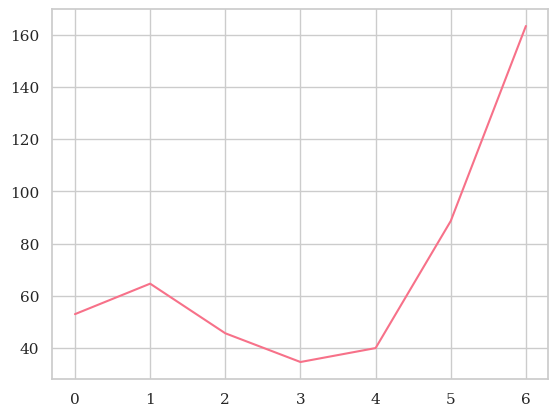

In [21]:
plt.plot(sim)

In [22]:
criteria_sim = "greatest_local_max"
if criteria_sim == "strict_local_max": #get local max that is greater or equal to 66% of global max and minimizes the lag
    best_idx = find_local_max_idx(sim, valid_criteria="strict") - E #reset reference. Sample [E:-E] corresponds to lag=0, sample [0:len(e_i)-2E] has lag =-E etc.
    if best_idx.size>0:
        best_idx = min(best_idx, key=abs) #get the smallest index (corresponds to the smallest lag)
    else:
        best_idx = 0 #if there is no local max that matches constraints, the lag is 0

elif criteria_sim == "local_max_min_lag": #get local max that minimizes the lag
    best_idx = find_local_max_idx(sim, valid_criteria=None) - E  #reset reference. Sample [E:-E] corresponds to lag=0, sample [0:len(e_i)-2E] has lag =-E etc.
    if best_idx.size>0:
        best_idx = min(best_idx, key=abs) #get the smallest index (corresponds to the smallest lag)
    else:
        best_idx = 0 #if there is no local max that matches constraints, the lag is 0            

elif criteria_sim == "greatest_local_max": #get greatest local maxima (regardless of min lag)
    best_idx = find_local_max_idx(sim, valid_criteria=None)
    if best_idx.size>0:
        best_idx = best_idx[np.argmax(sim[best_idx])] #get index of greatest local max
        best_idx = best_idx - E  #reset reference. Sample [E:-E] corresponds to lag=0, sample [0:len(e_i)-2E] has lag =-E etc.
    else:
        best_idx = 0 #if there is no local max that matches constraints, the lag is 0

elif criteria_sim == "global_max": #get simply the local max, regardless of lag value
    best_idx = np.argmax(sim) - E #reset reference. Obs. if values in sim are equal, by default takes the smallest argument
else:
    raise ValueError("criteria_sim should be amongst 'strict_local_max', 'local_max_min_lag', \
    'greatest_local_max', 'global_max' ")
    
best_idx + E

1

In [13]:
epochs_

<EpochsArray | 3 events (all good), 0 – 0.889 s (baseline off), ~6 kB, data loaded,
 '1': 3>

In [72]:
epoch_multiplier_list = [1,1,1]

epochs_weighted = apply_weights(epochs_, epoch_multiplier_list)
epochs_weighted.get_data()

array([[[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]],

       [[ 5.,  8.,  7.,  9.,  2.,  2., 10., 20., 30.]],

       [[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]]])

In [38]:
lags_list, cond_hist = compute_lags(epochs_, E=3)
lags_list

E:  3
Iteration num:  0
Iteration num:  1
Iteration num:  2
Iteration num:  3
Iteration num:  4
Iteration num:  5


[0, -2, 0]

In [39]:
lagged_epochs = apply_lags(epochs_,E=3,lags_list=lags_list)
lagged_epochs.get_data()

array([[[8., 7., 9.]],

       [[8., 7., 9.]],

       [[8., 7., 9.]]])

In [36]:
epochs_.get_data()

array([[[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]],

       [[ 5.,  8.,  7.,  9.,  2.,  2., 10., 20., 30.]],

       [[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]]])

In [ ]:
epochs_.get_data()